# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet and Engineering the Data Again

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

While it seems like the ResNet will increase the performance of the model on larger training sets, testing convergence is still a major problem. Now the input data will be modified to find the difference between each projection which should help the network better isolate the pattern we want it to find. This will hopefully allow for better understanding of the specific alignment problem by the neural network.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# The resulting function that can be used for modifying the data
def data_mean_difference(data):
    
    # Create copy of dataset for projections to be modified, also initializes array for mean projections
    projections = data[:, 0].copy()
    mean_projections = np.zeros((projections.shape[0]), dtype = object)
    
    # Iterate through each projection stack
    for i in range (projections.shape[0]):

        # Get rid of extra dimensions for neural networks and create a mean projection
        projections[i] = np.squeeze(projections[i])
        mean_projections[i] = np.mean(projections[i], axis = 0)

        # Iterate through every projection in stack
        for j in range (projections[0].shape[0]):

            # Change current projection to difference between current projection and mean projection
            projections[i][j] = projections[i][j] - mean_projections[i]
            
        # Expand dimensions to original form for neural networks
        projections[i] = np.expand_dims(projections[i], axis = 0)
        projections[i] = np.expand_dims(projections[i], axis = 0)

    # Create data difference array
    data_diff = data.copy()

    # Replace all data with the new difference projections
    for i in range (data.shape[0]):

        data_diff[i][0] = projections[i]
        
    return data_diff

In [4]:
def data_difference(data, entries):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((entries, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = (projections[i][j + 1] - projections[i][j])

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

In [5]:
def data_fourier_difference(data, entries):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((entries, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = fftshift(fft2((projections[i][j + 1] - projections[i][j])))

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

In [6]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)


# data = data_mean_difference(data)
# data = data_difference(data, entries)
data = data_fourier_difference(data, entries)

/tmp/ipykernel_7596/3725346712.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_diff[i][0][j] = differences[i, j]


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (200, 2)
Shape of Testing Dataset: (50, 2)


In [8]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [9]:
model = generate_model(101)
summary(model, (1, 1, 179, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 179, 64, 92]      21,952
├─BatchNorm3d: 1-2                       [1, 64, 179, 64, 92]      128
├─ReLU: 1-3                              [1, 64, 179, 64, 92]      --
├─MaxPool3d: 1-4                         [1, 64, 90, 32, 46]       --
├─Sequential: 1-5                        [1, 256, 90, 32, 46]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 32, 46]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 32, 46]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 32, 46]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 32, 46]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 32, 46]       --


In [10]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [11]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
# writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(101)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 8e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        # writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        # writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
# writer.flush()
# writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 8.946583440303803 
Epoch: 0   Validation Loss: 8.730485258102417 
Epoch: 1   Training Loss: 8.563282485008239 
Epoch: 1   Validation Loss: 8.731236429214478 
Epoch: 2   Training Loss: 8.553920073509216 
Epoch: 2   Validation Loss: 8.731493310928345 
Epoch: 3   Training Loss: 8.548536818027497 
Epoch: 3   Validation Loss: 8.731922359466553 
Epoch: 4   Training Loss: 8.544808430671692 
Epoch: 4   Validation Loss: 8.733757162094117 
Epoch: 5   Training Loss: 8.542531099319458 
Epoch: 5   Validation Loss: 8.73419228553772 
Epoch: 6   Training Loss: 8.54105136871338 
Epoch: 6   Validation Loss: 8.735283136367798 
Epoch: 7   Training Loss: 8.539730291366578 
Epoch: 7   Validation Loss: 8.735771207809448 
Epoch: 8   Training Loss: 8.53866276025772 
Epoch: 8   Validation Loss: 8.735870866775512 
Epoch: 9   Training Loss: 8.537869203090668 
Epoch: 9   Validation Loss: 8.7368620967865 
Epoch: 10   Training Loss: 8.5374440741539 
Epoch: 10   Validation Los

Epoch: 88   Training Loss: 8.535753667354584 
Epoch: 88   Validation Loss: 8.739013080596925 
Epoch: 89   Training Loss: 8.535740752220153 
Epoch: 89   Validation Loss: 8.739008855819701 
Epoch: 90   Training Loss: 8.535731897354125 
Epoch: 90   Validation Loss: 8.739005041122436 
Epoch: 91   Training Loss: 8.53572069644928 
Epoch: 91   Validation Loss: 8.739004163742065 
Epoch: 92   Training Loss: 8.53570517539978 
Epoch: 92   Validation Loss: 8.739004983901978 
Epoch: 93   Training Loss: 8.535693435668945 
Epoch: 93   Validation Loss: 8.739001741409302 
Epoch: 94   Training Loss: 8.535692353248596 
Epoch: 94   Validation Loss: 8.738999509811402 
Epoch: 95   Training Loss: 8.535681059360504 
Epoch: 95   Validation Loss: 8.738996477127076 
Epoch: 96   Training Loss: 8.535663783550262 
Epoch: 96   Validation Loss: 8.738995780944824 
Epoch: 97   Training Loss: 8.535665102005005 
Epoch: 97   Validation Loss: 8.738993635177613 
Epoch: 98   Training Loss: 8.53563934326172 
Epoch: 98   Valid

Epoch: 174   Training Loss: 8.52925374507904 
Epoch: 174   Validation Loss: 8.74931589126587 
Epoch: 175   Training Loss: 8.521814632415772 
Epoch: 175   Validation Loss: 8.75223274230957 
Epoch: 176   Training Loss: 8.524190385341644 
Epoch: 176   Validation Loss: 8.744199342727661 
Epoch: 177   Training Loss: 8.516524744033813 
Epoch: 177   Validation Loss: 8.753537607192992 
Epoch: 178   Training Loss: 8.51027394771576 
Epoch: 178   Validation Loss: 8.752309465408326 
Epoch: 179   Training Loss: 8.5004767537117 
Epoch: 179   Validation Loss: 8.752779712677002 
Epoch: 180   Training Loss: 8.527152645587922 
Epoch: 180   Validation Loss: 8.760156412124633 
Epoch: 181   Training Loss: 8.5453586602211 
Epoch: 181   Validation Loss: 8.743433246612549 
Epoch: 182   Training Loss: 8.535597174167632 
Epoch: 182   Validation Loss: 8.74799352645874 
Epoch: 183   Training Loss: 8.542893009185791 
Epoch: 183   Validation Loss: 8.742458505630493 
Epoch: 184   Training Loss: 8.536055734157562 
Ep

Epoch: 260   Training Loss: 8.420933406352997 
Epoch: 260   Validation Loss: 8.834563331604004 
Epoch: 261   Training Loss: 8.418830466270446 
Epoch: 261   Validation Loss: 8.818293924331664 
Epoch: 262   Training Loss: 8.436672821044922 
Epoch: 262   Validation Loss: 8.835298299789429 
Epoch: 263   Training Loss: 8.471258862018585 
Epoch: 263   Validation Loss: 8.814960870742798 
Epoch: 264   Training Loss: 8.4607203912735 
Epoch: 264   Validation Loss: 8.81635136604309 
Epoch: 265   Training Loss: 8.434680783748627 
Epoch: 265   Validation Loss: 8.801943273544312 
Epoch: 266   Training Loss: 8.441438043117524 
Epoch: 266   Validation Loss: 8.813825788497924 
Epoch: 267   Training Loss: 8.413400905132294 
Epoch: 267   Validation Loss: 8.820210752487183 
Epoch: 268   Training Loss: 8.407303466796876 
Epoch: 268   Validation Loss: 8.826812620162963 
Epoch: 269   Training Loss: 8.405207796096802 
Epoch: 269   Validation Loss: 8.831503047943116 
Epoch: 270   Training Loss: 8.4047981977462

Epoch: 346   Training Loss: 8.536865653991699 
Epoch: 346   Validation Loss: 8.739329147338868 
Epoch: 347   Training Loss: 8.536827344894409 
Epoch: 347   Validation Loss: 8.739304685592652 
Epoch: 348   Training Loss: 8.536831607818604 
Epoch: 348   Validation Loss: 8.73920488357544 
Epoch: 349   Training Loss: 8.536717312335968 
Epoch: 349   Validation Loss: 8.739208726882934 
Epoch: 350   Training Loss: 8.536678040027619 
Epoch: 350   Validation Loss: 8.739223699569703 
Epoch: 351   Training Loss: 8.536650402545929 
Epoch: 351   Validation Loss: 8.739221076965332 
Epoch: 352   Training Loss: 8.536625137329102 
Epoch: 352   Validation Loss: 8.739225463867188 
Epoch: 353   Training Loss: 8.536583275794984 
Epoch: 353   Validation Loss: 8.739224061965942 
Epoch: 354   Training Loss: 8.536544120311737 
Epoch: 354   Validation Loss: 8.739202089309693 
Epoch: 355   Training Loss: 8.536524729728699 
Epoch: 355   Validation Loss: 8.739224615097045 
Epoch: 356   Training Loss: 8.53647424697

Epoch: 432   Training Loss: 8.535644044876099 
Epoch: 432   Validation Loss: 8.738955135345458 
Epoch: 433   Training Loss: 8.535636713504791 
Epoch: 433   Validation Loss: 8.738953771591186 
Epoch: 434   Training Loss: 8.535617864131927 
Epoch: 434   Validation Loss: 8.738969230651856 
Epoch: 435   Training Loss: 8.535618500709534 
Epoch: 435   Validation Loss: 8.738978881835937 
Epoch: 436   Training Loss: 8.535619223117829 
Epoch: 436   Validation Loss: 8.738981857299805 
Epoch: 437   Training Loss: 8.535614557266236 
Epoch: 437   Validation Loss: 8.738889436721802 
Epoch: 438   Training Loss: 8.535599188804627 
Epoch: 438   Validation Loss: 8.738946313858031 
Epoch: 439   Training Loss: 8.535607235431671 
Epoch: 439   Validation Loss: 8.7389554977417 
Epoch: 440   Training Loss: 8.535611433982849 
Epoch: 440   Validation Loss: 8.738902311325074 
Epoch: 441   Training Loss: 8.535594007968903 
Epoch: 441   Validation Loss: 8.738936862945557 
Epoch: 442   Training Loss: 8.535582363605

KeyboardInterrupt: 

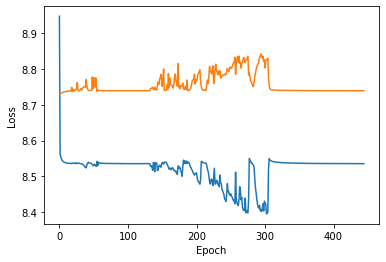

In [12]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This shows that there is still not testing convergence, so this method of providing the differences in this matter will be abandoned for now. The next possible solution will use the cross correlation of the original projection and its reprojection, which will hopefully provide positive results similarly to the existing traditional algorithm.